## Exploratory Data Analysis & Feature Definition
Hourly info on how much electricity homes use (UCI file).  
The goal is to get ideas that directly drive useful impact for prediction.

### 1. Project Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import Markdown, display
import seaborn as sns
import sys
sys.path.append('../')
from src.data_preparation import download_and_extract_data
from statsmodels.tsa.seasonal import seasonal_decompose

plt.style.use('seaborn-v0_8-whitegrid') 
pd.set_option('display.max_columns', 50)

### 2. Raw Data Inspection and handlling nulls

In [13]:
raw_path = r'C:\Users\AliRashaideh\OneDrive - Seagulls\Desktop\energy_forecasting_project\data\raw\household_power_consumption.csv'
DATA_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip"
RAW_DIR = './data/raw'
raw_file_path = download_and_extract_data(DATA_URL, RAW_DIR)

Downloading: 19.7MB [00:04, 4.65MB/s]


Extracting dataset...


In [14]:
print("Loading data...")
df_without_na = pd.read_csv(raw_file_path, sep=';')
print("Loading data...")
df = pd.read_csv(raw_file_path, sep=';', na_values=['?', 'nan'], parse_dates={'datetime': ['Date', 'Time']})
df.set_index('datetime', inplace=True)

Loading data...


C:\Users\AliRashaideh\AppData\Local\Temp\ipykernel_18184\2964537705.py:2: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_without_na = pd.read_csv(raw_file_path, sep=';')
C:\Users\AliRashaideh\AppData\Local\Temp\ipykernel_18184\2964537705.py:4: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(raw_file_path, sep=';', na_values=['?', 'nan'], parse_dates={'datetime': ['Date', 'Time']})


Loading data...


C:\Users\AliRashaideh\AppData\Local\Temp\ipykernel_18184\2964537705.py:4: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(raw_file_path, sep=';', na_values=['?', 'nan'], parse_dates={'datetime': ['Date', 'Time']})


In [18]:
print("Data without NA:")
print(df_without_na.info())
print(df_without_na.describe().T)
print(df_without_na.isnull().sum())


Data without NA:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB
None
                    count      mean       std  min  25%  50%   75%   max
Sub_metering_3  2049280.0  6.458447  8.437154  0.0  0.0  1.0  17.0  31.0
Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3        

In [19]:

print("Data with NA detection:")
print(df.info())
print(df.describe().T)
print(df.isnull().sum())

Data with NA detection:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB
None
                           count        mean       std      min      25%  \
Global_active_power    2049280.0    1.091615  1.057294    0.076    0.308   
Global_reactive_power  2049280.0    0.123714  0.112722    0.000    0.048   
Voltage                2049280.0  240.839858  3.239987  223.200  238.990   
Global_intensity       2049280.0    4.627759  4.444396    0.200    1.400   
Sub_metering_1         2049280.0    1.121923  6.153031    0.000    0.000   
Sub_

In [20]:
df.fillna(method='ffill', inplace=True)
df.drop_duplicates(inplace=True)
print("\nMissing values after imputation:")
print(df.isnull().sum())

C:\Users\AliRashaideh\AppData\Local\Temp\ipykernel_18184\1624033518.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)



Missing values after imputation:
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


In [21]:
df.shape

(1906698, 7)

there is differnce when we dropped dublicate as we can see:

data shape before: (2075259, 7)

data shape after: (1906698, 7)



## EDA

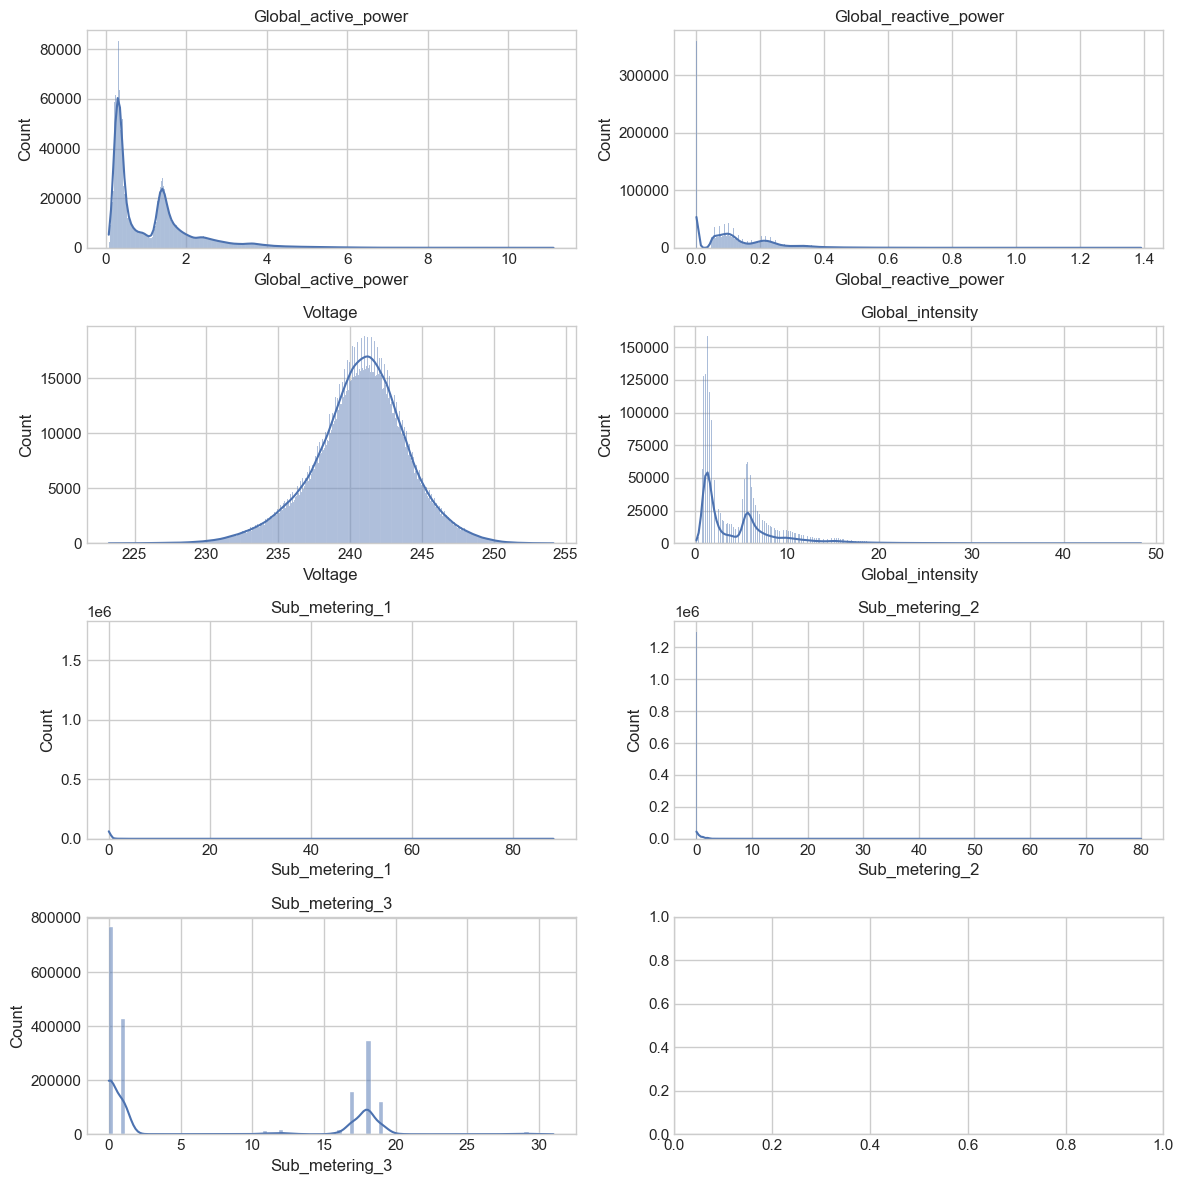

In [22]:
numeric_cols = df.select_dtypes(include=np.number).columns
rows = (len(numeric_cols) + 1) // 2
fig, axes = plt.subplots(rows, 2, figsize=(12, 3 * rows))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    sns.histplot(df[col].dropna(), kde=True, ax=axes[i])
    axes[i].set_title(col)
plt.tight_layout()
plt.show()

1. histograms
Active, reactive power & intensity

Most measurements are low, but a few hours can go up to very high numbers.
The "outliers" are the spikes on the far right.

Voltage
It looks like a nice bell shape with a center about 241 V. No clear outliers and can be normally disterbutred.

Sub-metering 1 & 2
Almost always zero; they only spike when the specific appliance is on.

Sub-metering 3
Has three clear levels: off, medium (15 Wh) and high (30 Wh). The rare points above 30 Wh are the only extreme values worth flagging.

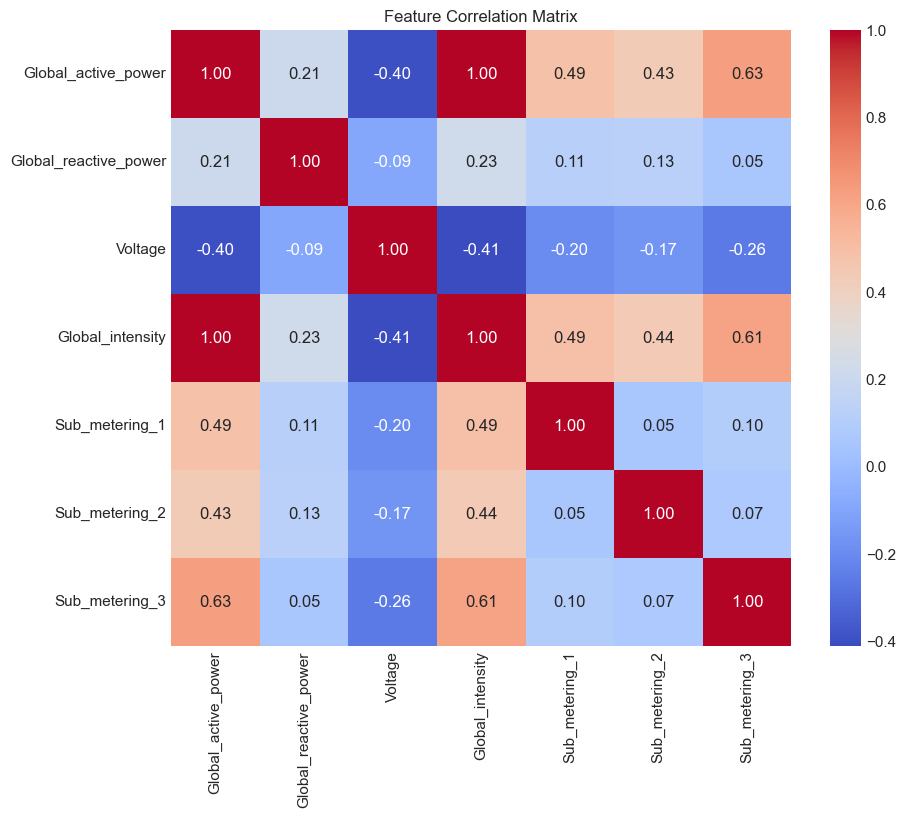

In [23]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

2. Correlation heat-map

Active power ↔ Intensity: basically the same thing (correlation ≈ 1).

Active power ↔ Sub-metering 3: strong link channel 3 lead huge loads. 

Voltage ↔ Load: light negative link voltage dips slightly when load rises.

Sub-metering 1 & 2: almost independent of total load.

Sub-metering  3 and voltage are useful extra predictors; sub-metering 1/2 add little.

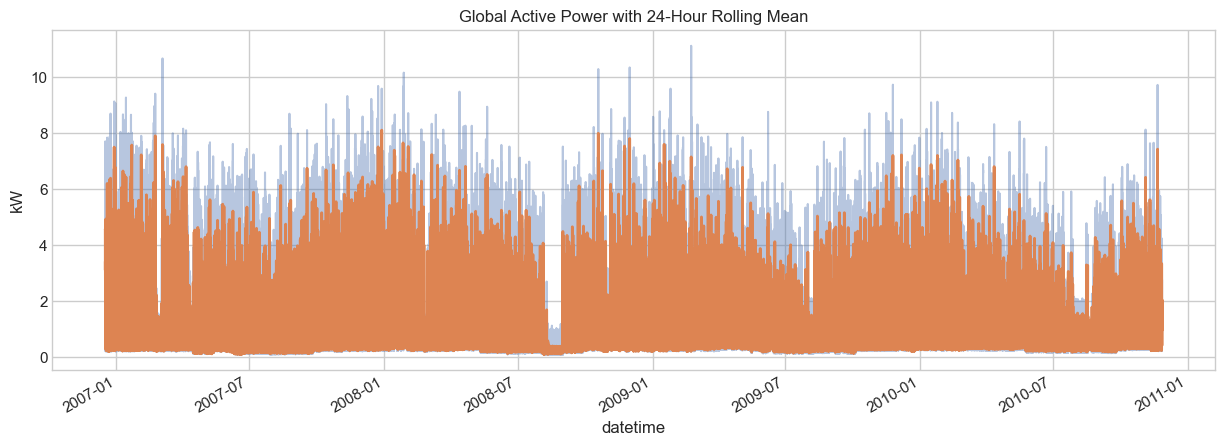

In [24]:
plt.figure(figsize=(15, 5))
df['Global_active_power'].plot(alpha=0.4)
df['Global_active_power'].rolling(24).mean().plot(linewidth=2)
plt.title('Global Active Power with 24-Hour Rolling Mean')
plt.ylabel('kW')
plt.show()


3. Active power with 24 h rolling mean

Clear winter peaks and summer dips → yearly seasonality.

A long flat strip around mid-2008 is missing data.

Separated rises above the orange 24-h average corroborate the outliers noticed before.

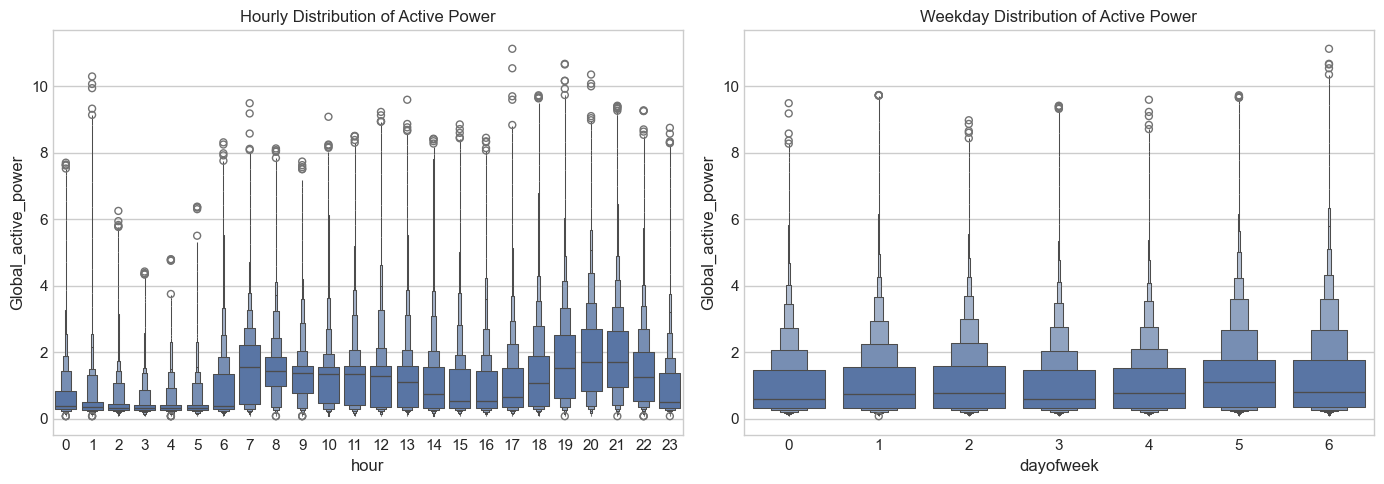

In [25]:
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.boxenplot(x='hour', y='Global_active_power', data=df, ax=axes[0])
axes[0].set_title('Hourly Distribution of Active Power')
sns.boxenplot(x='dayofweek', y='Global_active_power', data=df, ax=axes[1])
axes[1].set_title('Weekday Distribution of Active Power')
plt.tight_layout()
plt.show()

4. Hour-of-day & Day-of-week box-plots

load grows from sunrise, peaks at 17-22 h, lowers overnight. 

Weekdays vs. weekends: weekends are a little higher and more spaced out. 

Dots above  represent the same high-load outliers.

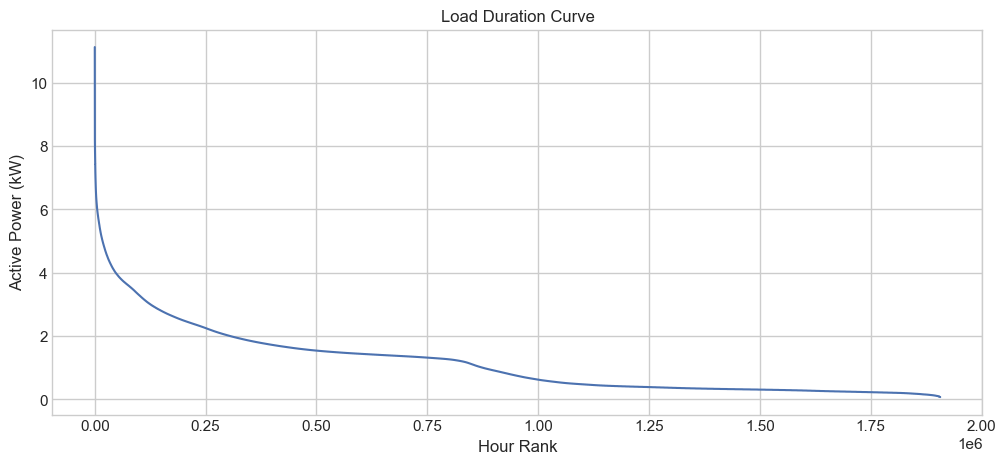

In [26]:
sorted_load = df['Global_active_power'].sort_values(ascending=False).reset_index(drop=True)
plt.figure(figsize=(12, 5))
plt.plot(sorted_load.values)
plt.title('Load Duration Curve')
plt.xlabel('Hour Rank')
plt.ylabel('Active Power (kW)')
plt.show()


5. Load-duration curve

95 % of the time the house uses < 2 kW.

The top 1 % of hours jump to > 10 kW—rare but real heavy-use periods.

No sudden downs, so extreme points appear good. 

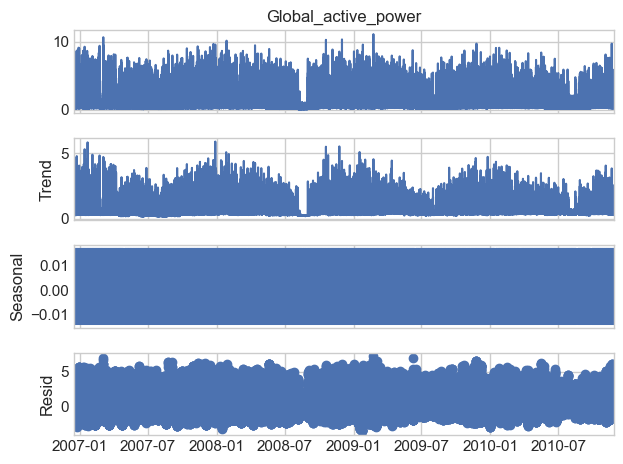

In [27]:
res = seasonal_decompose(df['Global_active_power'], model='additive', period=168)
res.plot()
plt.show()

6. Weekly seasonal decomposition (168 h period)

Trend: repeats the annual up-and-down cycle. 

Seasonal (weekly) part: virtually flat weekly cycle is weak. 

Residuals: waves line up with the high-load spikes..

### Conclusions
Outliers exist only in power/intensity variables—real peaks rather than device mistakes.

Mid-2008 gap must be fixed or removed.

Useful time features: hour, weekday/weekend, month, plus 24-h & 168-h rolling stats.

Key drivers: sub-metering 3 and slight voltage dips during high load.

Feature shortlist:

Hour, day-of-week, month, weekend flag

Lag-24, lag-48, lag-168 for active power & sub-metering 3

Rolling mean & std (24 h, 168 h)

Holiday

Engineered Data:


<Axes: title={'center': 'Holiday Distribution'}, xlabel='is_holiday_or_weekend'>

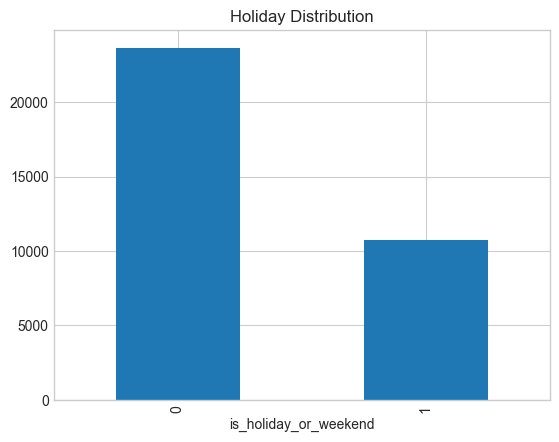

In [15]:
import holidays
engineered_data= pd.read_csv(r'../data/processed/hourly_featured.csv', parse_dates=['datetime'])
engineered_data.set_index('datetime', inplace=True)


print("Engineered Data:")

engineered_data['is_holiday_or_weekend'].value_counts().plot(kind='bar', title='Holiday Distribution')
#display data where is holiday


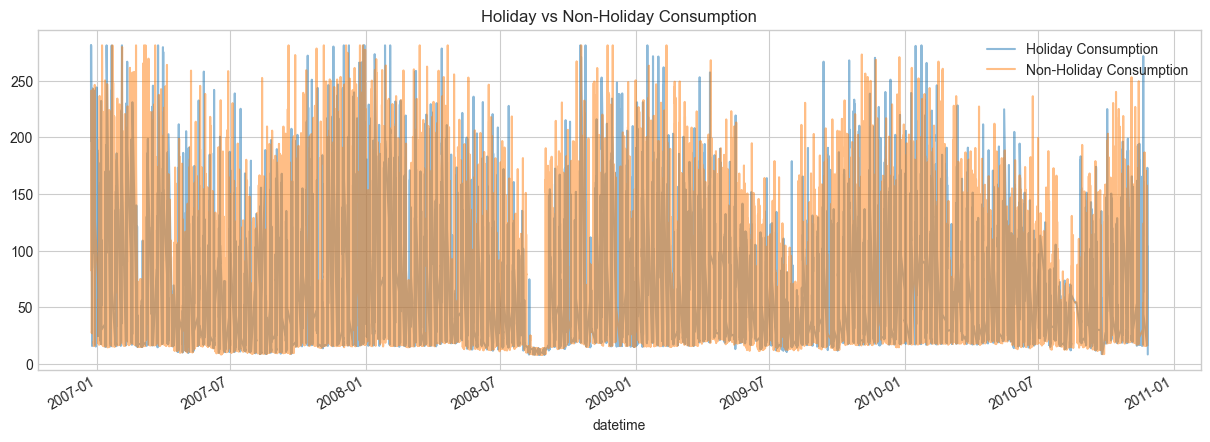

In [21]:
holiday_data = engineered_data[engineered_data['is_holiday_or_weekend'] == 1]
non_holiday_data = engineered_data[engineered_data['is_holiday_or_weekend'] == 0]
plt.figure(figsize=(15, 5))
holiday_data['Global_active_power'].plot(label='Holiday Consumption', alpha=0.5)
non_holiday_data['Global_active_power'].plot(label='Non-Holiday Consumption', alpha=0.5)
plt.title('Holiday vs Non-Holiday Consumption')
plt.legend()
plt.show()

In [25]:
# show how much each column contributes to the target variable
contribution = engineered_data.corr()['Global_active_power'].drop('Global_active_power').abs()
contribution.sort_values(ascending=False, inplace=True)
print("Feature Contribution to Target Variable:")
print(contribution)


Feature Contribution to Target Variable:
Global_intensity                        0.999418
Sub_metering_3                          0.705247
Global_active_power_lag_168             0.461213
Global_active_power_lag_24              0.444589
Global_active_power_rolling_mean_24     0.410361
Global_active_power_lag_48              0.406840
Voltage                                 0.372141
Global_active_power_rolling_std_24      0.364083
Sub_metering_2                          0.360037
Global_active_power_rolling_mean_168    0.339022
hour                                    0.331644
Global_active_power_rolling_std_168     0.315265
Sub_metering_3_lag_168                  0.306862
Global_reactive_power                   0.305750
Sub_metering_3_lag_24                   0.293875
Voltage_rolling_std_24                  0.274894
Sub_metering_3_lag_48                   0.273686
Voltage_rolling_std_168                 0.246751
Voltage_lag_168                         0.194585
Voltage_lag_24              